# Dataset Preparation for Prediction of Imminent ICU Admission and Prolonged Stay

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import math
import numpy as np
import pandas as pd
import spacy

import seaborn as sns
sns.set(style = 'darkgrid')

import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path

from utils.splits import set_group_splits
from args import args
vars(args)

{'workdir': PosixPath('../data/workdir'),
 'figdir': PosixPath('../data/workdir/figdir'),
 'raw_csv': PosixPath('../data/raw_dataset.csv'),
 'proc_csv': PosixPath('../data/proc_dataset.csv'),
 'imminent_adm_cols': ['hadm_id', 'imminent_adm_label'],
 'prolonged_stay_cols': ['hadm_id', 'prolonged_stay_label']}

## Stats

In [3]:
df = pd.read_csv(args.proc_csv)
print(df.columns)
print(df.shape)

ia_df = df.loc[(df['imminent_adm_label'] != -1)][args.imminent_adm_cols].reset_index(drop=True)
ps_df = df[args.prolonged_stay_cols].copy()

Index(['subject_id', 'hadm_id', 'icustay_id', 'admission_type', 'admittime',
       'dischtime', 'intime', 'outtime', 'charttime', 'icu_los', 'deathtime',
       'adm_to_icu_period', 'charttime_to_icu_period', 'chartinterval',
       'ethnicity', 'dob', 'gender', 'admission_age', 'category',
       'imminent_adm_label', 'prolonged_stay_label', 'note', 'processed_note'],
      dtype='object')
(75271, 23)


Make sure average prevalence of random test sets is approximately same as real prevalence

In [4]:
ia_p = []
ps_p = []

for seed in range(127, 227):
  sdf = set_group_splits(ia_df.copy(), group_col='hadm_id', seed=seed)
  test_size = len(sdf.loc[(sdf['split'] == 'test')])
  test_pos = len(sdf.loc[(sdf['split'] == 'test') & (sdf['imminent_adm_label'] == 1)])
  ia_p.append(test_pos/test_size)  
  
  sdf = set_group_splits(ps_df.copy(), group_col='hadm_id', seed=seed)
  test_size = len(sdf.loc[(sdf['split'] == 'test')])
  test_pos = len(sdf.loc[(sdf['split'] == 'test') & (sdf['prolonged_stay_label'] == 1)])
  ps_p.append(test_pos/test_size)  
  

ia_p = np.array(ia_p)
ps_p = np.array(ps_p)

print(f"Prevalence of Imminent Admission: {(len(ia_df.loc[ia_df['imminent_adm_label'] == 1])/len(ia_df)):0.3f}")
print(f"Average of test set = {(ia_p.mean()):0.3f}, std = {(ia_p.std()):0.3f}")
print(f"Prevalence of Prolonged Stay: {(len(ps_df.loc[ps_df['prolonged_stay_label'] == 1])/len(ps_df)):0.3f}")
print(f"Average of test set = {(ps_p.mean()):0.3f}, std = {(ps_p.std()):0.3f}")

Prevalence of Imminent Admission: 0.236
Average of test set = 0.240, std = 0.020
Prevalence of Prolonged Stay: 0.366
Average of test set = 0.363, std = 0.033


In [5]:
print(f"Average number of notes per admission for imminent admission: {ia_df.groupby('hadm_id').size().mean():0.2f}")
print(f"Average number of notes per admission for prolonged stay (and entire dataset): {ps_df.groupby('hadm_id').size().mean():0.2f}")

Average number of notes per admission for imminent admission: 7.34
Average number of notes per admission for prolonged stay (and entire dataset): 5.85


In [6]:
df.groupby(df['deathtime'].apply(lambda x: True if pd.notnull(x) else False))['subject_id'].nunique().reset_index()

,deathtime,subject_id
0,False,10367
1,True,1628


In [7]:
df.groupby(df['gender'])['subject_id'].nunique().reset_index()

,gender,subject_id
0,F,5085
1,M,6755


In [8]:
df.groupby(df['ethnicity'])['subject_id'].nunique().reset_index()

,ethnicity,subject_id
0,asian,283
1,black,778
2,hispanic,377
3,unknown,1791
4,white,8634


In [9]:
df.groupby(df['admission_type'])['hadm_id'].nunique().reset_index()

,admission_type,hadm_id
0,ELECTIVE,2425
1,EMERGENCY,9995
2,URGENT,457


Distribution of notes by category

In [10]:
df.groupby(df['category']).size().reset_index()

,category,0
0,Case Management,28
1,Consult,5
2,General,285
3,Nursing,8831
4,Nursing/other,15523
5,Nutrition,433
6,Pharmacy,6
7,Physician,4109
8,Radiology,44526
9,Rehab Services,222


Distribution of notes by category for imminent admissions and delayed admissions

In [21]:
df.loc[(df['imminent_adm_label'] == 1)].groupby('category').size().reset_index()

,category,0
0,Case Management,3
1,Consult,1
2,General,32
3,Nursing,981
4,Nursing/other,1099
5,Nutrition,24
6,Physician,448
7,Radiology,9360
8,Rehab Services,22
9,Respiratory,27


In [17]:
df.loc[(df['imminent_adm_label'] == 0)].groupby('category').size().reset_index()

,category,0
0,Case Management,19
1,Consult,4
2,General,220
3,Nursing,6556
4,Nursing/other,12205
5,Nutrition,361
6,Pharmacy,6
7,Physician,2963
8,Radiology,15150
9,Rehab Services,146


Distribution of notes for prolonged stay and short stay

In [22]:
df.loc[(df['prolonged_stay_label'] == 1)].groupby('category').size().reset_index()

,category,0
0,Case Management,9
1,Consult,2
2,General,88
3,Nursing,3231
4,Nursing/other,6812
5,Nutrition,168
6,Physician,1438
7,Radiology,15186
8,Rehab Services,83
9,Respiratory,513


In [23]:
df.loc[(df['prolonged_stay_label'] == 0)].groupby('category').size().reset_index()

,category,0
0,Case Management,19
1,Consult,3
2,General,197
3,Nursing,5600
4,Nursing/other,8711
5,Nutrition,265
6,Pharmacy,6
7,Physician,2671
8,Radiology,29340
9,Rehab Services,139


In [25]:
df.groupby('admission_age')['subject_id'].unique().reset_index()['admission_age'].describe().reset_index()

,index,admission_age
0,count,5103.000000
1,mean,64.385336
2,std,35.009108
3,min,17.000000
4,25%,48.155000
5,50%,62.350000
6,75%,75.815000
7,max,307.400000


In [26]:
df['icu_los'].describe().reset_index()

,index,icu_los
0,count,75271.000000
1,mean,5.828632
2,std,12.589301
3,min,0.000100
4,25%,1.577300
5,50%,2.941900
6,75%,5.886600
7,max,173.072500


In [28]:
df['adm_to_icu_period'].describe().reset_index()

,index,adm_to_icu_period
0,count,75271.000000
1,mean,14.277002
2,std,16.132856
3,min,0.000000
4,25%,4.230000
5,50%,9.710000
6,75%,17.860000
7,max,141.290000


In [29]:
df['charttime_to_icu_period'].describe().reset_index()

,index,charttime_to_icu_period
0,count,75271.000000
1,mean,8.645746
2,std,11.004952
3,min,0.000000
4,25%,1.680000
5,50%,5.220000
6,75%,11.360000
7,max,141.170000


## Plots

In [ ]:
df = pd.read_csv(args.proc_csv)
df.columns

In [31]:
intervals = ['-1 ≤ t ≤ 0']
intervals += [f'-{i+1} ≤ t ≤ -{i}' for i in range(1, 15)]
intervals.append('t ≤ -15')

### Bar Plot of Notes Over Days

#### All Notes

In [32]:
plot_df = pd.DataFrame(df.groupby(['chartinterval']).size(), columns=['n_notes'])
plot_df.reset_index(inplace=True, drop=True)
plot_df['days'] = intervals

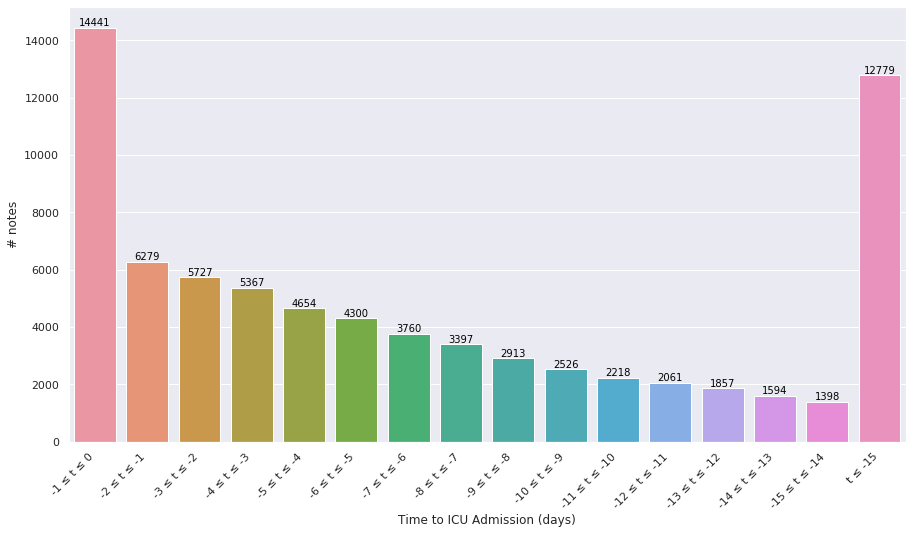

In [33]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x='days', y='n_notes', data=plot_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
ax.set_xlabel('Time to ICU Admission (days)')
ax.set_ylabel('# notes')
for index, row in plot_df.iterrows():
    ax.text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom')

In [ ]:
# fig.savefig(args.figdir/'note_bp.tif', dpi=300)

#### By Category

In [ ]:
def plot_intervals(ax, df, cat):
  sns.barplot(x='days', y='n_notes', data=df, ax=ax)
  ax.set_xticklabels(ax.get_xticklabels(),rotation=45, ha='right')
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title(f"Note Category: {cat}\n# notes: {df['n_notes'].sum()}")   

  for index, (_, row) in enumerate(df.iterrows()):
      ax.text(index, row['n_notes'], str(row['n_notes']), color='black', ha='center', va='bottom')    

In [ ]:
plot_df = pd.DataFrame(df.groupby(['category', 'chartinterval']).size(), columns=['n_notes'])
plot_df.reset_index(inplace=True)
plot_df['days'] = plot_df['chartinterval'].apply(lambda x: intervals[x])
plot_df.drop(['chartinterval'], inplace=True, axis=1)

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(20, 50))
plot_intervals(ax[0][0], plot_df.loc[plot_df['category'] == 'Case Management ', ['n_notes', 'days']], 'Case Management')
plot_intervals(ax[0][1], plot_df.loc[plot_df['category'] == 'Consult', ['n_notes', 'days']], 'Consult')

plot_intervals(ax[1][0], plot_df.loc[plot_df['category'] == 'General', ['n_notes', 'days']], 'General')
plot_intervals(ax[1][1], plot_df.loc[plot_df['category'] == 'Nursing', ['n_notes', 'days']], 'Nursing')

plot_intervals(ax[2][0], plot_df.loc[plot_df['category'] == 'Nursing/other', ['n_notes', 'days']], 'Nursing/other')
plot_intervals(ax[2][1], plot_df.loc[plot_df['category'] == 'Nutrition', ['n_notes', 'days']], 'Nutrition')

plot_intervals(ax[3][0], plot_df.loc[plot_df['category'] == 'Pharmacy', ['n_notes', 'days']], 'Pharmacy')
plot_intervals(ax[3][1], plot_df.loc[plot_df['category'] == 'Physician ', ['n_notes', 'days',]], 'Physician')

plot_intervals(ax[4][0], plot_df.loc[plot_df['category'] == 'Radiology', ['n_notes', 'days']], 'Radiology')
plot_intervals(ax[4][1], plot_df.loc[plot_df['category'] == 'Rehab Services', ['n_notes', 'days']], 'Rehab Services')

plot_intervals(ax[5][0], plot_df.loc[plot_df['category'] == 'Respiratory ', ['n_notes', 'days']], 'Respiratory')
plot_intervals(ax[5][1], plot_df.loc[plot_df['category'] == 'Social Work', ['n_notes', 'days']], 'Social Work')

fig.text(0.5, 0.1, 'Time to ICU Admission (days)', ha='center')
fig.text(0.08, 0.5, '# notes', va='center', rotation='vertical')

plt.subplots_adjust(hspace = 0.3)

In [ ]:
# cats = sorted(list(df['category'].unique()))

# n = 0
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# plot_intervals(ax, plot_df.loc[plot_df['category'] == cats[n], ['n_notes', 'days']], cats[n])
# ax.set_xlabel('Time to ICU Admission (days)')
# ax.set_ylabel('# notes')

In [ ]:
# fig.savefig(args.figdir/'note_cats_bp.tif', dpi=300)

### Note Chart Time to ICU Admission Period Histogram

#### All Notes

In [ ]:
plot_df = df[['category', 'chart_icu_period']]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(plot_df['chart_icu_period'], kde=False, ax=ax, bins=80)
ax.set_xlabel('Period between Note Chart Time and ICU Admission Time (days)')
ax.set_ylabel('# notes')
ax.set_xlim(0, 60)

# ax.text(ax.get_xlim()[1]*0.50, ax.get_ylim()[1]*0.80, f"Min: {mdf['chart_icu_period'].min()}, Avg: {mdf['chart_icu_period'].mean(): 0.2f}, Max: {mdf['chart_icu_period'].max()}", fontweight='bold', fontsize=15, ha='center', va='bottom')

In [ ]:
# fig.savefig(args.figdir/'note_icu_period_hist.tif', dpi=300)

#### By Category

In [ ]:
def plot_period(ax, df, cat):
  sns.distplot(df, kde=False, ax=ax, bins=10)
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.set_title(f"Note Category: {cat}")   

In [ ]:
fig, ax = plt.subplots(6, 2, figsize=(20, 50))
plot_period(ax[0][0], plot_df.loc[plot_df['category'] == 'Case Management ', ['chart_icu_period']], 'Case Management')
plot_period(ax[0][1], plot_df.loc[plot_df['category'] == 'Consult', ['chart_icu_period']], 'Consult')

plot_period(ax[1][0], plot_df.loc[plot_df['category'] == 'General', ['chart_icu_period']], 'General')
plot_period(ax[1][1], plot_df.loc[plot_df['category'] == 'Nursing', ['chart_icu_period']], 'Nursing')

plot_period(ax[2][0], plot_df.loc[plot_df['category'] == 'Nursing/other', ['chart_icu_period']], 'Nursing/other')
plot_period(ax[2][1], plot_df.loc[plot_df['category'] == 'Nutrition', ['chart_icu_period']], 'Nutrition')

plot_period(ax[3][0], plot_df.loc[plot_df['category'] == 'Pharmacy', ['chart_icu_period']], 'Pharmacy')
plot_period(ax[3][1], plot_df.loc[plot_df['category'] == 'Physician ', ['chart_icu_period',]], 'Physician')

plot_period(ax[4][0], plot_df.loc[plot_df['category'] == 'Radiology', ['chart_icu_period']], 'Radiology')
plot_period(ax[4][1], plot_df.loc[plot_df['category'] == 'Rehab Services', ['chart_icu_period']], 'Rehab Services')

plot_period(ax[5][0], plot_df.loc[plot_df['category'] == 'Respiratory ', ['chart_icu_period']], 'Respiratory')
plot_period(ax[5][1], plot_df.loc[plot_df['category'] == 'Social Work', ['chart_icu_period']], 'Social Work')

fig.text(0.5, 0.11, 'Period between Note Chart Time and ICU Admission Time (days)', ha='center')
fig.text(0.08, 0.5, '# notes', va='center', rotation='vertical')

plt.subplots_adjust(hspace = 0.1)

In [ ]:
# cats = sorted(list(df['category'].unique()))

# n = 0
# fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# plot_period(ax, plot_df.loc[plot_df['category'] == cats[n], ['chart_icu_period']], cats[n])
# ax.set_xlabel('Time to ICU Admission (days)')
# ax.set_ylabel('# notes')

In [ ]:
# fig.savefig(args.figdir/'note_cat_icu_period_hist.tif', dpi=300)

### Hospital Admission to ICU Admission Period Histogram

In [ ]:
plot_df = df[['adm_icu_period']]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.distplot(plot_df, kde=False, ax=ax, bins=80)
ax.set_xlabel('Time between hospital admission and ICU admission (days)')
ax.set_ylabel('# notes')
ax.set_xlim(0, 70)
# ax.text(ax.get_xlim()[1]*0.50, ax.get_ylim()[1]*0.80, f"Min: {mdf['adm_icu_period'].min()}, Avg: {mdf['adm_icu_period'].mean(): 0.2f}, Max: {mdf['adm_icu_period'].max()}", fontweight='bold', fontsize=15, ha='center', va='bottom')    

In [ ]:
# fig.savefig(args.figdir/'adm_icu_period_hist.tif', dpi=300)

### Note Length Histogram

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df['note'].apply(len), kde=False, ax=ax, bins=100)
ax.set_xlabel('Length of Note (characters)')
ax.set_ylabel('# notes')

In [ ]:
# fig.savefig(args.figdir/'note_len_hist.tif', dpi=300)

### Imminent ICU Prediction Class Distribution

In [34]:
desc = ['not used', 'negative class', 'positive class']

#### Without Admissions

In [ ]:
plot_df = pd.DataFrame(df.groupby(['imminent_label']).size(), columns=['n_notes']).reset_index()
plot_df['imminent_label'] = desc
plot_df = plot_df.reindex([2, 1, 0])
plot_df.reset_index(inplace=True, drop=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='imminent_label', y='n_notes', data=plot_df, ax=ax)
ax.set_xlabel('Imminent Class Label')
ax.set_ylabel('# notes')
for index, row in plot_df.iterrows():
  ax.text(index+0.05, row['n_notes']+50, str(row['n_notes']), color='black', ha='right', va='bottom')

In [ ]:
# fig.savefig(args.figdir/'imminent_label_bp.tif', dpi=300)

#### With Admissions

In [ ]:
p1 = pd.DataFrame(df.groupby(['imminent_label']).size(), columns=['n_notes']).reset_index()
p2 = df.groupby(['imminent_label'])['hadm_id'].nunique().reset_index()
p = p1.merge(p2, on=['imminent_label'])

In [ ]:
p['imminent_label'] = desc

In [ ]:
p = p.reindex([2,1,0])
p.reset_index(inplace=True, drop=True)
p

In [ ]:
plot_df = p.copy()
plot_df.rename(columns={'hadm_id':'# Admissions', 'n_notes':'# Notes'}, inplace=True)
plot_df = pd.melt(plot_df, id_vars='imminent_label', var_name='Legend', value_name='counts')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x='imminent_label', y='counts', hue='Legend', data=plot_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
ax.set_xlabel('Imminent Class Label')
ax.set_ylabel('# notes')

for index, row in plot_df.iterrows():
    if index < len(plot_df)//2:
        ax.text(index-0.13, row['counts']+50, str(row['counts']), color='black', ha='right', va='bottom')
    else:
        ax.text(index % (len(plot_df)//2)+0.25, row['counts']+50, str(row['counts']), color='black', ha='right', va='bottom')

In [ ]:
# fig.savefig(args.figdir/'imminent_label_adms_bp.tif', dpi=300)

### Discharge ICU Prediction Class Distribution

In [ ]:
desc = ['negative class', 'positive class']

#### Without Admissions

In [ ]:
plot_df = pd.DataFrame(df.groupby(['discharge_label']).size(), columns=['n_notes']).reset_index()
plot_df['discharge_label'] = desc
plot_df = plot_df.reindex([1, 0])
plot_df.reset_index(inplace=True, drop=True)
plot_df

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='discharge_label', y='n_notes', data=plot_df, ax=ax)
ax.set_xlabel('5 Day Discharge Class Label')
ax.set_ylabel('# notes')
for index, row in plot_df.iterrows():
  ax.text(index+0.05, row['n_notes']+50, str(row['n_notes']), color='black', ha='right', va='bottom')

In [ ]:
# fig.savefig(args.figdir/'discharge_label_bp.tif', dpi=300)

#### With Admissions

In [ ]:
p1 = pd.DataFrame(df.groupby(['discharge_label']).size(), columns=['n_notes']).reset_index()
p2 = df.groupby(['discharge_label'])['hadm_id'].nunique().reset_index()
p = p1.merge(p2, on=['discharge_label'])
p['discharge_label'] = desc
p = p.reindex([1,0])
p.reset_index(inplace=True, drop=True)
p

In [ ]:
plot_df = p.copy()
plot_df.rename(columns={'hadm_id':'# Admissions', 'n_notes':'# Notes'}, inplace=True)
plot_df = pd.melt(plot_df, id_vars='discharge_label', var_name='Legend', value_name='counts')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.barplot(x='discharge_label', y='counts', hue='Legend', data=plot_df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), ha='right')
ax.set_xlabel('5 Day Discharge Class Label')
ax.set_ylabel('# notes')

for index, row in plot_df.iterrows():
    if index < len(plot_df)//2:
        ax.text(index-0.13, row['counts']+50, str(row['counts']), color='black', ha='right', va='bottom')
    else:
        ax.text(index % (len(plot_df)//2)+0.25, row['counts']+50, str(row['counts']), color='black', ha='right', va='bottom')

In [ ]:
# fig.savefig(args.figdir/'discharge_label_adms_bp.tif', dpi=300)